# Graduation Likelihood Prediction

* Dataset: [Kaggle | mohansacharya/graduate-admissions](https://www.kaggle.com/datasets/mohansacharya/graduate-admissions)

In this notebook, we will develop a model that will predict the likelihood for a college student's application for their Masters degree to be accepted. We will not dive to deep into model building but instead stay on surface level, simple visualizations and simple model configurations.

## Libraries

* `pandas` _for data loading & manipulation_
* `sklearn` _for training the machine learning models_
* `seaborn` _for advanced data visualization_

## Install libraries

In [15]:
# ! pip install scikit-learn seaborn

## Import Libraries

In [16]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

## Library versions

In [17]:
print(f"Python: {sys.version}")
print(f"Sci-Kit Learn: {sklearn.__version__}")
print(f"Seaborn: {sns.__version__}")

Python: 3.11.10 (main, Sep 27 2024, 06:09:18) [GCC 12.2.0]
Sci-Kit Learn: 1.5.2
Seaborn: 0.13.2


# Load Dataset

Make sure your dataset in the same directory as this notebook, this will ensure an easy loading of the dataset. Also name the CSV file as `dataset.csv`

In [18]:
DATASET_PATH = Path("dataset.csv")

if not DATASET_PATH.exists():
    raise FileNotFoundError(f"{DATASET_PATH} not found")
else:
    print(f"{DATASET_PATH} found")

dataset.csv found


In [19]:
df = pd.read_csv(DATASET_PATH)
df = df.set_index(df.columns[0])
COLUMNS = df.columns.values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 1 to 500
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 35.2 KB


The output from `df.info()` shows that there aren't any null values in the dataset which is a good thing as we don't have to take an extra step to fix such an issue.

__Note__: The following step is __Optional__. We are changing the datatypes of the values to a datatype thatb uses a smaller memory footprint. For 500 rows, it does not make a difference and is shown for demonstration purposes.

In [20]:
df = df.astype({
    COLUMNS[0]: "uint16",
    COLUMNS[1]: "uint16",
    COLUMNS[2]: "uint8",
    COLUMNS[3]: "float16",
    COLUMNS[4]: "float16",
    COLUMNS[5]: "float16",
    COLUMNS[6]: "uint8",
    COLUMNS[7]: "float16"
})

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 1 to 500
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    uint16 
 1   TOEFL Score        500 non-null    uint16 
 2   University Rating  500 non-null    uint8  
 3   SOP                500 non-null    float16
 4   LOR                500 non-null    float16
 5   CGPA               500 non-null    float16
 6   Research           500 non-null    uint8  
 7   Chance of Admit    500 non-null    float16
dtypes: float16(4), uint16(2), uint8(2)
memory usage: 10.7 KB


# Data Visualization

## Correlation Plot

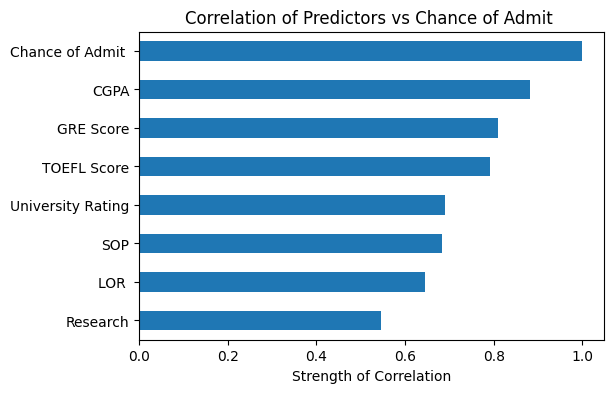

In [21]:
_, ax = plt.subplots(figsize=(6,4))
df.corr("pearson").iloc[: , -1].sort_values(ascending=True).plot(kind="barh", ax=ax)
ax.set_xlabel("Strength of Correlation")
ax.set_title(f"Correlation of Predictors vs {COLUMNS[-1]}")
plt.show()

As we can see from this chart, except for `Research`, all other predictors have a moderate to strong correlation with `Chance of Admit`. We can __drop the predictor `Research`__ if we want to. Also rating based predcitors like `Statement of Purpose`, `Letter of Recommendation` show moderate correlation with the target variable.

We can make the following conclusions:

1. Applicants must focus on improving their CGPA, GRE and TOEFL scores to boost their chances of getting an admission in the University they aspire to.
2. An applicants academic performance during their undergraduate years are very important as the correlation between `CGPA` scores and `Chance of Admit` is quite higher than that of `GRE` and `TOEFL` scores.

## Seaborn Pair Plot

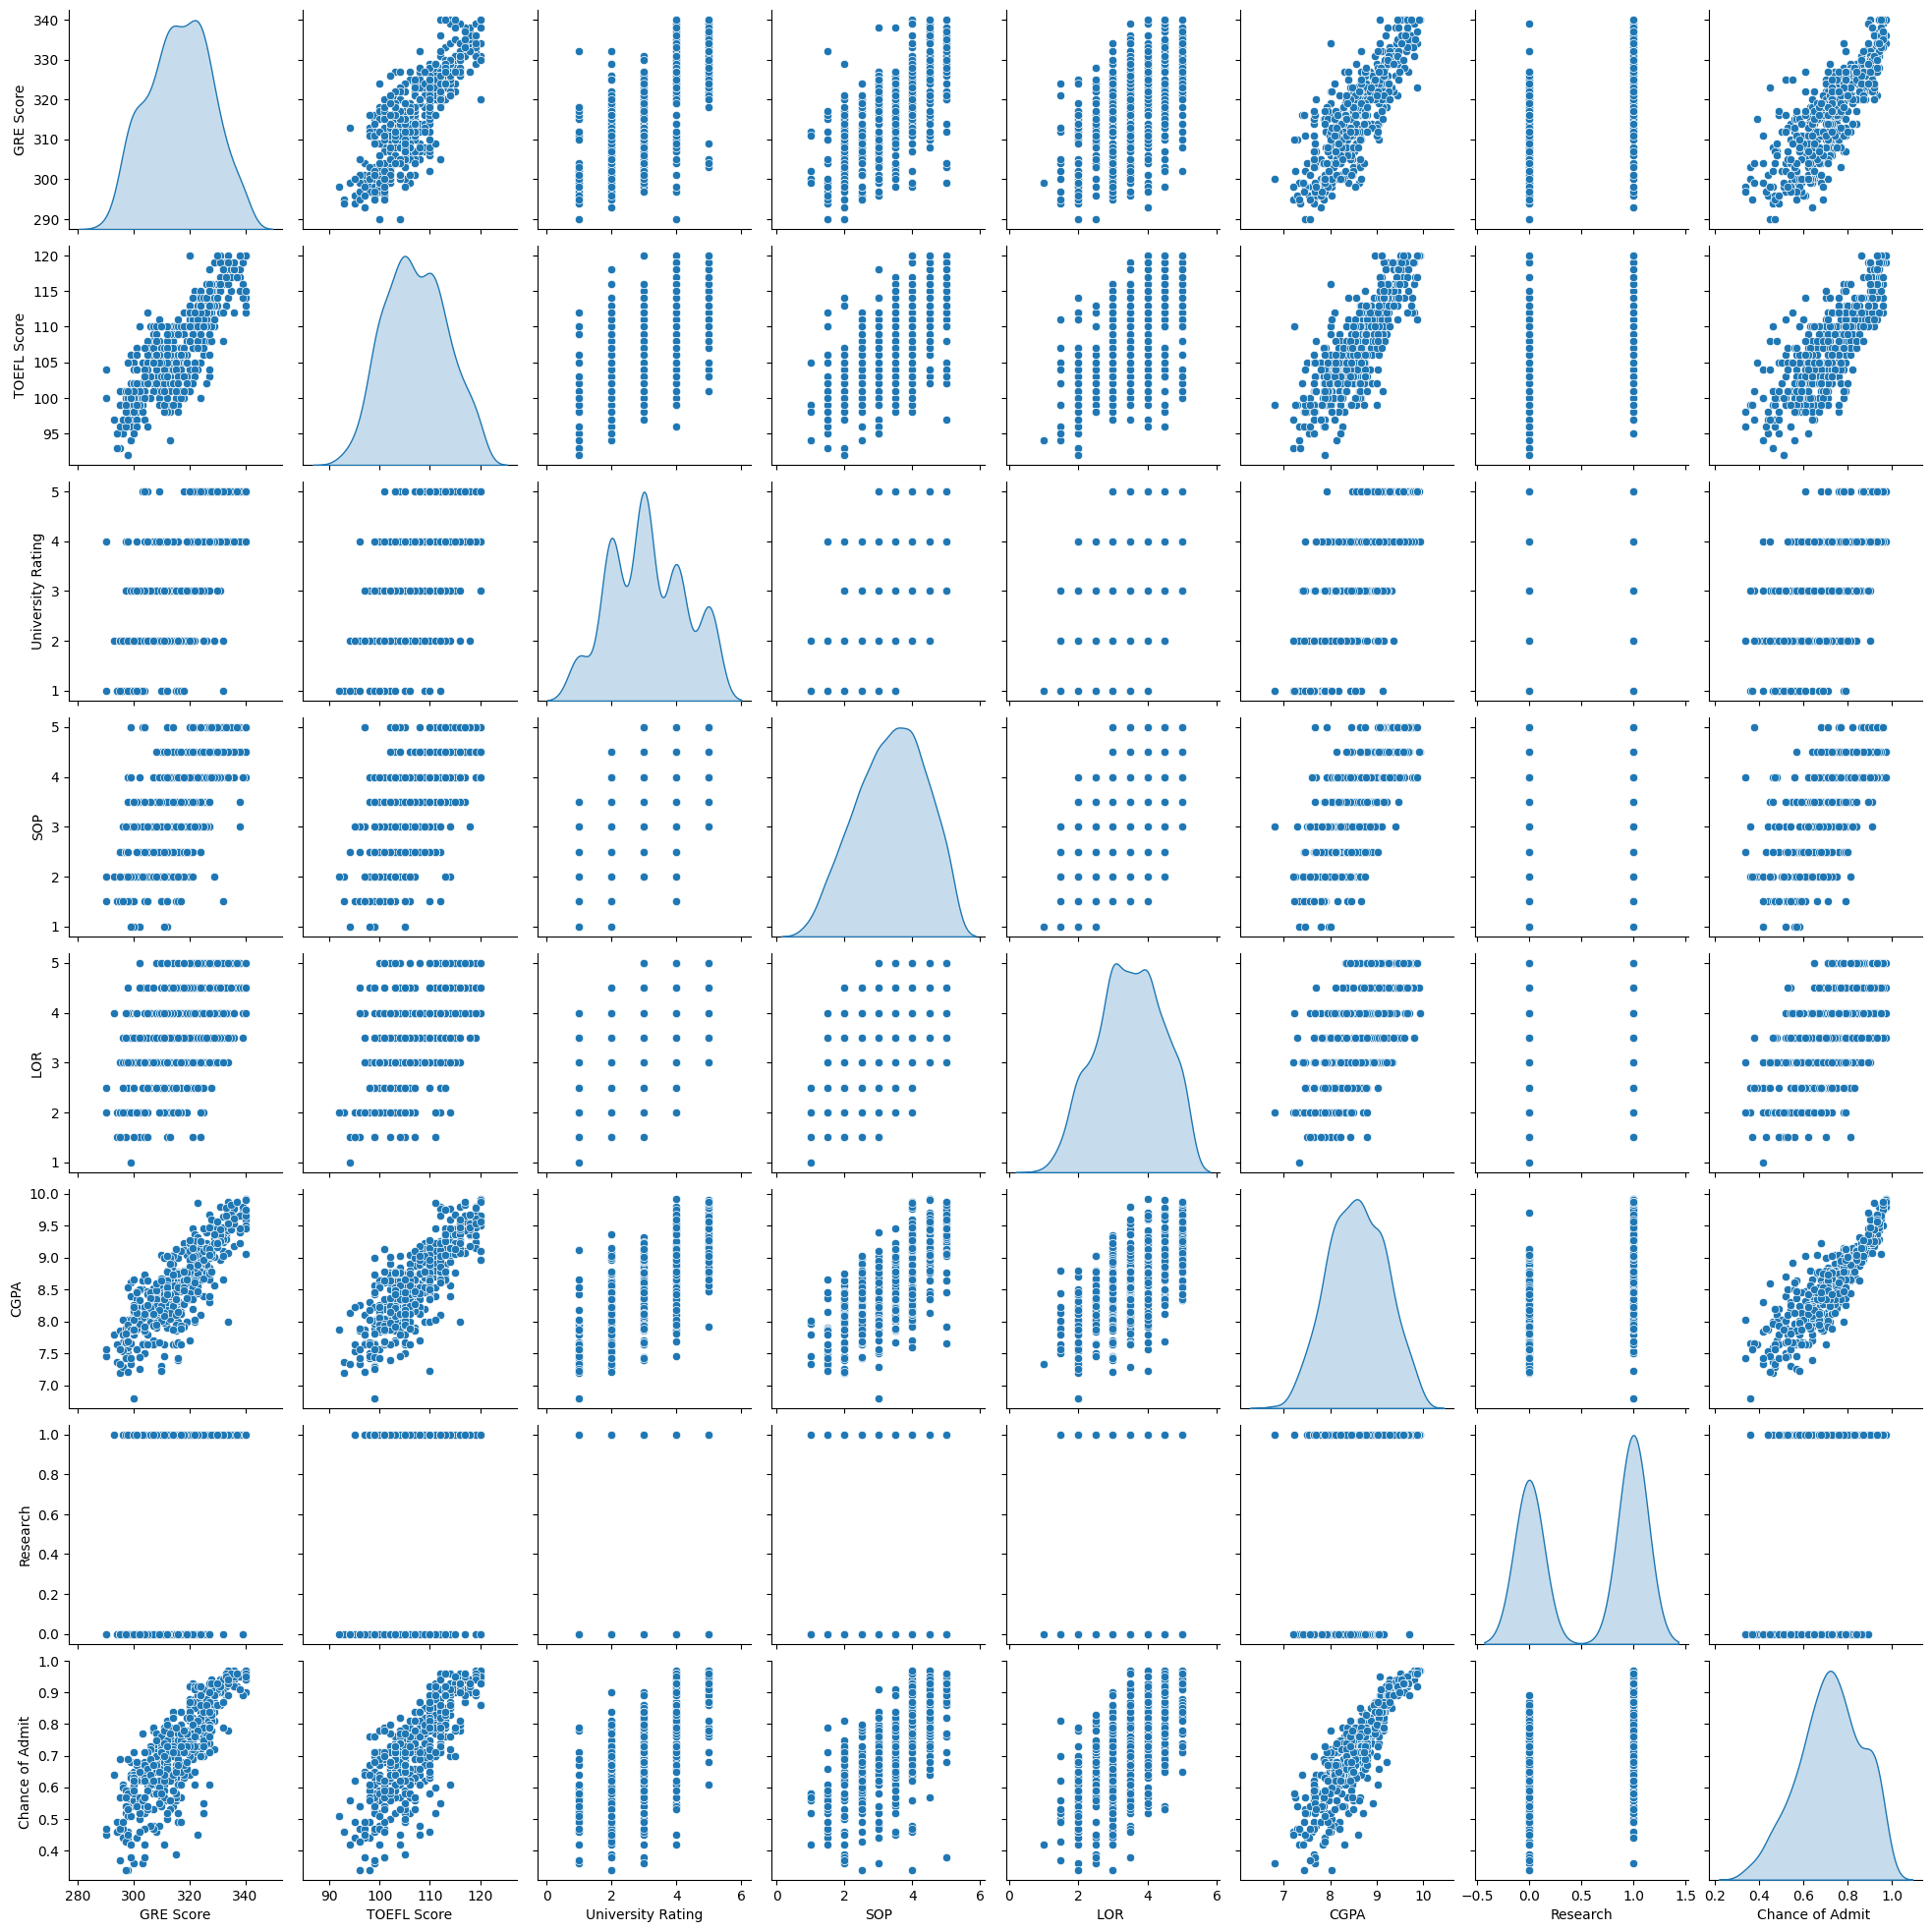

In [22]:
sns.pairplot(df, diag_kind='kde')

# Prepare dataset for Model Training

## Separate _Features_ & _Target_ Variables

In [23]:
X = df.drop(columns=COLUMNS[-1])
y = df.loc[:, COLUMNS[-1]]

## Split dataset into _Training_ & _Evaluation_ sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Model Training

## Hyperparameters

In [25]:
MAX_TREES = 100
TREE_DEPTH = 3
SEED = 1337

## Train the Model

In [26]:
rf_model = RandomForestRegressor(n_estimators=MAX_TREES, max_depth=TREE_DEPTH, random_state=SEED).fit(X_train, y_train)

## Feature Importance Scores

Random Forest has an internal algorithm that assigns a score to individual features on a scale from 0 to 1. The higher the score implies a higher importance.

In [27]:
(
    pd.DataFrame(
        data={"score": rf_model.feature_importances_},
        index=rf_model.feature_names_in_
    )
    .sort_values('score', ascending=False)
    .assign(agg_score=lambda df: df['score'].cumsum())
)

,score,agg_score
CGPA,0.864719,0.864719
GRE Score,0.110296,0.975015
TOEFL Score,0.015611,0.990626
Research,0.003343,0.993969
LOR,0.002456,0.996426
University Rating,0.002035,0.998461
SOP,0.001539,1.000000


__Note:__ From the feature importances table, we can see that `CGPA` and `GRE Score` account for a combined of __98%__ of feature importance, which means that if we use these two features only then we can capture around 98% of the correlation.

## Evaluation metrics

In [28]:
def eval_metrics(model, features_test, target_test):
    target_pred = model.predict(features_test)
    return {
        "mse": mean_squared_error(target_test, target_pred),
        "r2": r2_score(target_test, target_pred)
    }

In [29]:
rf_metrics = eval_metrics(rf_model, X_test, y_test)
print(f"Mean Squared Error: {rf_metrics['mse']}")
print(f"R2 Score: {rf_metrics['r2']}")

Mean Squared Error: 0.003982716134639134
R2 Score: 0.8052721698744284


# _Top 3 most important Features_ Model

Using the top 3 features based on the __Feature Importance Scores__ obtained from our trained Random Forest model, we will build a simpler model. This will reduce the computational complixities of our model significantly.

## Extract the features

In [30]:
df_reduced = df.loc[:, COLUMNS[[0, 1, 5, 7]]]

In [31]:
X = df_reduced.drop(columns=COLUMNS[-1])
y = df_reduced.loc[:, COLUMNS[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## Hyperparameters

In [53]:
KERNEL = "linear"
TOLERANCE = 1e-5
LOSS_PENALTY = 0.5

## Train Model

In [56]:
sv_model = SVR(kernel=KERNEL, tol=TOLERANCE, C=LOSS_PENALTY, verbose=True).fit(X_train, y_train)

[LibSVM]*
optimization finished, #iter = 205
obj = -1.073038, rho = 0.878520
nSV = 53, nBSV = 51


In [55]:
sv_metrics = eval_metrics(sv_model, X_test, y_test)
print(f"Mean Squared Error: {sv_metrics['mse']}")
print(f"R2 Score: {sv_metrics['r2']}")

Mean Squared Error: 0.004176064698828273
R2 Score: 0.7958187353112701


# _Most Important Feature_ Model

In [36]:
df_reduced = df.loc[:, COLUMNS[[5, 7]]]

X = df_reduced.drop(columns=COLUMNS[-1])
y = df_reduced.loc[:, COLUMNS[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [37]:
sv_model = LinearRegression()

In [38]:
sv_model.fit(X_train, y_train)
print(f"Support Vector Machine Score: {sv_model.score(X_test, y_test)}")

Support Vector Machine Score: 0.80615234375


In [39]:
rf_model.fit(X_train, y_train)
print(f"Random Forest Machine Score: {rf_model.score(X_test, y_test)}")

Random Forest Machine Score: 0.8092322680498716
